In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
%%time
import pandas as pd
import numpy as np
import os
import ants

CPU times: user 2.13 s, sys: 3.24 s, total: 5.37 s
Wall time: 9.5 s


In [11]:
# rlbls = pd.read_csv('../Data/GlasserAtlas/glasser360NodeNames.txt',header=None)
# rlbls = rlbls[0].to_list()
# rlbls = np.array(rlbls)
# drop_rois = np.array(['Left_OFC' 'Right_TGv' 'Right_OFC' 'Left_TGv' 'Right_s32' 'Left_s32'
#  'Left_pOFC' 'Right_25' 'Left_25' 'Right_LO2' 'Right_TE1m' 'Right_pOFC'])

In [18]:
df = pd.read_csv('../Data/ABIDE_df3.csv')
df.sample(5)

,Unnamed: 0,participant_id,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,bids_folder,site,funcFile
837,837,51198,2,NaN,12.2546,1,Ambi,NaN,114.0,109.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-Stanford0051198,16,Stanford_0051198_func_preproc.nii.gz
552,552,50775,2,0.0,11.0000,1,R,85.0,101.0,NaN,...,6.0,12.0,9.0,11.0,1,NaN,NaN,sub-KKI0050775,4,KKI_0050775_func_preproc.nii.gz
1019,1019,51559,2,0.0,27.0000,1,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-SBL0051559,14,SBL_0051559_func_preproc.nii.gz
933,933,51317,1,1.0,12.8200,1,R,NaN,102.0,99.0,...,NaN,NaN,NaN,NaN,1,12.82,NaN,sub-UCLA20051317,18,UCLA_2_0051317_func_preproc.nii.gz
858,858,51220,1,1.0,14.7400,1,R,NaN,99.0,121.0,...,NaN,NaN,NaN,NaN,1,14.74,NaN,sub-UCLA10051220,18,UCLA_1_0051220_func_preproc.nii.gz


In [17]:
rlbls = pd.read_csv('../Data/GlasserAtlas/rnames_trimmed.csv')
rlbls.sample(5)

,Unnamed: 0,lbl,idx,idx2
94,96,Right_i6-8,97,95
60,61,Right_d32,62,61
226,233,Left_6d,234,227
172,179,Right_p24,180,173
259,266,Left_9a,267,260


In [103]:
def get_split_cmats(flat_epi,flat_rois):
    
#     this_epi = flat_epi.copy()
#     this_rois = flat_rois.copy()
    
    this_epi = flat_epi
    this_rois = flat_rois
    
    nTR = flat_epi.shape[1]
    mid = int(nTR/2)

    assert this_rois.shape[0] == this_epi.shape[0],'u stupid'

    e = this_rois!=0
    e *= abs(this_epi).sum(axis=1)>10

    this_epi = this_epi[e,:]
    this_rois = this_rois[e]
    
    buffer = 10
    first_half = this_epi[:,0:mid-buffer]
    second_half = this_epi[:,mid+buffer::]

    assert abs(first_half.shape[1]-second_half.shape[1])<5,'dumbass gonna dumb'

    roi_timeseries1 = np.array([first_half[this_rois==r,:].mean(axis=0) for r in range(1,int(this_rois.max())+1)])
    roi_timeseries2 = np.array([second_half[this_rois==r,:].mean(axis=0) for r in range(1,int(this_rois.max())+1)])

    cmat1 = np.corrcoef(roi_timeseries1)
    cmat2 = np.corrcoef(roi_timeseries2)
    
    #res['cmat1'] = cmat1
    #res['cmat2'] = cmat1
    
    #res['roi_timeseries1'] = roi_timeseries1
    #res['roi_timeseries2'] = roi_timeseries2
    
    return cmat1,cmat2

In [92]:
epi_rois = ants.image_read('../Data/GlasserAtlas/epi_rois_trimmed.nii.gz')
flat_rois = epi_rois.numpy().reshape(-1)

In [20]:
nsubs = len(df)
func_dir = '../../data/ABIDE/Outputs/cpac/filt_noglobal/func_preproc/'

In [126]:
from tqdm import tqdm
rel_cmats = np.zeros((len(df),len(rlbls),len(rlbls),2))

In [127]:
%%time
for s in tqdm(range(len(df))):
    funcFile = df['funcFile'].values[s]
    epi = ants.image_read(os.path.join(func_dir,funcFile))
    flat_epi = epi.numpy().reshape(-1,epi.shape[-1])

    cmat1,cmat2 = get_split_cmats(flat_epi,flat_rois)
    
    rel_cmats[s,:,:,0] = cmat1
    rel_cmats[s,:,:,1] = cmat2

 14%|█▎        | 144/1048 [04:58<32:07,  2.13s/it]<ipython-input-103-731ce0f59311>:26: RuntimeWarning:

Mean of empty slice.

/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-103-731ce0f59311>:27: RuntimeWarning:

Mean of empty slice.

100%|██████████| 1048/1048 [40:20<00:00,  2.31s/it]

CPU times: user 31min 13s, sys: 5min 47s, total: 37min 1s
Wall time: 40min 20s


In [128]:
np.savez_compressed(file='../Assets/glasser2016_cmats/filt_noglobal/rel-cmats',rel_cmats=rel_cmats)

In [129]:
rel_cmats.shape

(1048, 348, 348, 2)

In [171]:
rel_cmats = np.load('../Assets/glasser2016_cmats/filt_noglobal/rel-cmats.npz')['rel_cmats']

In [159]:
from helper_funcs import get_triu
from matplotlib import pyplot as plt

In [173]:
rel_cmats = rel_cmats[np.isnan(rel_cmats).sum(-1).sum(-1).sum(-1)==0,:,:,:]
print(np.isnan(rel_cmats).sum())

0


In [187]:
rel_cmats.shape

(1038, 348, 348, 2)

In [174]:
n = rel_cmats.shape[0]
flat_c1 = np.array([get_triu(rel_cmats[s,:,:,0]) for s in range(n)])
flat_c2 = np.array([get_triu(rel_cmats[s,:,:,1]) for s in range(n)])

In [176]:
rel_vals = np.array([np.corrcoef(flat_c1[s,:],flat_c2[s,:])[0,1] for i in range(n)])
print(rel_vals.mean())

0.5261117259957799


In [177]:
# RANK SIM
big_sim = np.corrcoef(np.vstack((flat_c1,flat_c2)))
big_sim.shape

(2076, 2076)

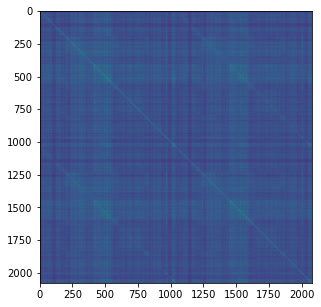

In [183]:
plt.figure(figsize=(5,5))
plt.imshow(big_sim)

In [180]:
first_second_sim = big_sim[0:n,:][:,n:]

In [185]:
s = 0
#first_second_sim

In [204]:
def getRank(s):
    vec = first_second_sim[s,:]
    within = vec[s]
    between = vec[np.arange(n)!=s]
    rank = (within<between).sum()+1
    return rank

In [213]:
ranks = np.array([getRank(s) for s in range(n)])

In [215]:
(ranks==1).mean()

0.9441233140655106